# Feature extraction

**Note:** This presently uses the cleaned FHR as output by MATLAB (as not yet got match from Python for the pre-processing).

## Set up

In [1]:
# Import packages
from dataclasses import dataclass
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, sosfiltfilt
from scipy import io

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    clean_fhr = './fhrma/train_test_data/clean_fhr_matlab/'
    fhrma_taylor = './fhrma/T_orig.mat'


paths = Paths()

## Background

### Feature types

In the context of the FIGO guidelines, the routinely judged FHR components, often called **FIGO-based or morphological features**, are the baseline heart rate, variability, accelerations, and decelerations. These components are the most robust indicators to ascertain fetal well-being. For this reason, in almost all studies that address automated CTG analysis, these basic morphological features are confirmed as an indispensable part of the analyses. The initial studies on automated CTG analysis focused on the detection of morphological features that clinicians examine with the naked eye, but this is challenging due to a lack of standards on how computers estimate the diagnostic indices.[[source]](https://doi.org/10.1016/j.bspc.2018.05.016)

Studies have since explored the use of other features from **linear, non-linear, discrete wavelet transform (DWT), empirical mode decomposition (EMD), time-frequency and image-based time-frequency (IBTF) domains**.[[source]](https://doi.org/10.1016/j.bspc.2018.05.016)

### Methods and software for automated CTG analysis/feature extraction during labour

Refer to `03_literature_review` for some of the publications describing this, as well as examples of commercial software for this, that have been evaluated in clinical practice.

## FHR Baseline

The FHR baseline is defined as the **mean of the signal after accelerations and decelerations have been excluded**. It is challenging to define a method for determining the FHR baseline because:
* It has a circular definition, as accelerations and decelerations are defined as periods when the signal is consistently above or below the baseline.
* There is high variability in some recordings, making it hard to distinguish between change in the baseline, and an acceleration or deceleration.[[source]](https://doi.org/10.3389/fped.2023.1190441)

M'Barek et al. 2023 state that you can overcome this issue by calibrating your method on baselines, accelerations and decelerations annotated by a consensus of obstetricians (they use those on the FHRMA dataset).[[source]](https://doi.org/10.3389/fped.2023.1190441)

Different methods have been explored for calculation of FHR baseline, with main detailed in `03_literature_review.md`. Below, I have attempted to implement one of the more simple methods.

### Taylor et al. 2000

[Taylor et al. 2000](https://doi.org/10.1111/j.1471-0528.2000.tb11112.x) - The development and validation of an algorithm for real-time computerised fetal heart rate monitoring in labour

As described in their paper, this involves:

1. **Interpolation of invalid data points:** Remove periods of signal loss by detecting large deviations in fetal heart rate, and values outside of accepted range of 55-200bpm. These readings are discarded and replaced by linear interpolation between valid data points.

2. **Use Butterworth filter to generate coarse starting baseline:** Low pass filter using third order zero-phase (two-pass) Butterworth filter with frequency cut off of 0.008Hz

3. **Remove deviations, perform interpolation, and apply butterworth filter** Remove deviations of +- 5bpm from the initial baseline. Then linear interpolation. Then low pass Butterworth filter with cut-off frequency of 0.006 Hz. This was a lower cut off frequency than that used for obtaining the starting baseline, because many of the deviations from the baseline had already been removed in the first filtering process that generated the starting baseline.

4. **Repeat that twice more**. This creates a three-stage process the generates progressively improved intermediary baselines.

5. **Determine baseline**. The mean value of baseline for a give period (e.g. they show 25-minute segment) gives the baseline fetal heart rate for that segment.

### Implementation in MATLAB

Boudet et al. implement Taylor et al. in the FHRMA toolbox, as in [this MATLAB function](https://github.com/utsb-fmm/FHRMA/blob/master/aamtaylor.m) which is copied below. It uses [FHRMA::butterfilt()](https://github.com/utsb-fmm/FHRMA/blob/master/butterfilt.m), which is a complete butterworth filter process. It also uses [FHRMA::interpolFHR](https://github.com/utsb-fmm/FHRMA/blob/master/interpolFHR.m), which replaces 0s in FHR corresponding to signal missing by linear interpolation.

I can't spot the mentioned pre-processing stages about periods of signal loss. It's unclear from Taylor et al. 2000 whether this only referred to extreme values, or whether there were certain lengths of time that were dropped (which is common in CTG pre-processing).

```
FHRi=FHR;
FHRbl=FHRi;

bl1=butterfilt(FHRi,4,0,0.008,3,1);
FHRbl(FHRi-bl1>5)=0;
FHRbl(FHRi-bl1<-5)=0;

bl2=butterfilt(interpolFHR(FHRbl),4,0,0.006,3,1);
FHRbl(FHRi-bl2>5)=0;
FHRbl(FHRi-bl2<-5)=0;

bl3=butterfilt(interpolFHR(FHRbl),4,0,0.006,3,1);
FHRbl(FHRi-bl3>10)=0;
FHRbl(FHRi-bl3<-5)=0;

baseline=butterfilt(interpolFHR(FHRbl),4,0,0.006,3,1);
``````

To explain their butterworth filter, with first example:
* Signal = FHRi
* Sampling rate = 4
* F1 = 0, meaning low pass at F2
* F2 = 0.008
* Order of filter = 3
* Forward-Backward filter = 1 means True

### Explanation of butterworth filters

Copied from: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

Consider the example data below. When you zoom in, you can see the noise in the data. If you wanted to find the point where the curve starts its rise, it would be difficult due to the noise making it likely you get a false positive result, and the performance of the algorithm would be impacted by the fluctuation in the data too.

![Signal](./images/noisy_signal.png)
![Zoomed in](./images/noisy_signal_zoom.png)

In signal processing, there are four common filters:
* **Low-pass filters** = pass signals below cut-off and attenuate signals above it
* **High-pass filters** = pass signals above cut-off and attenuate signals below it
* **Band-pass filters** = combination of low-pass and high-pass filter, passes frequencies that fall between the two cut-offs
* **Band-reject/band-stop/notch filters** = passes frequencies that fall outside of the range of the low-pass and high-pass cutoffs

The range of frequencies that a filter can pass through is called its **passband**. The range of frequencies attentuated or not passed by a filter is its **stopband**. A filter can have more than one - e.g. a bandpass filter has a passband with a high stopband above and low stopband below.

A **frequency response** refers to how a filter/signal processing system changes the amplitude and phase of various frequencies in the signal. Its usually represented graphically with a **response curve** showing the magnitude/amplitude and phase shift of the output signal compared to the input signal, across a range of frequencies.

![Filter types](./images/filter_types.png)

One type of signal processing filter is the **butterworth filter** (also known as the maximally flat magnitude filter).

The butterworth filter has a **flat frequency response in the passband**, i.e. is maximally flat. This means that all frequencies in the passband are passed with the same amplification or attenuation, ensuring a uniform treatment of those frequencies. This doesn't mean that amplitude is removed, but instead means frequencies are treated equally, and there's no preferential treatment or emphasis on certain frequencies over others.

The butterworth filter also **rolls off to zero in the stopband** (gradual roll-off rate). Roll-off is the rate at which the filter transitions between the passband and stopband.

![Butterworth filter frequency response](./images/butterworth_frequency_response.png)


The order of the filters determines how rapidly the filters response changes from the passband to the stopband. High-order butterworth filters have steeper roll-off. Higher-order Butterworth filters provide a more rapid attenuation of frequencies outside the passband, but they might also introduce phase distortions or higher complexity in their implementation. Image below from [here](https://dsp.stackexchange.com/questions/60455/how-to-choose-order-and-cut-off-frequency-for-low-pass-butterworth-filter).

![Butterworth filter orders](./images/butterworth_orders.png)

Filters have a delay/lag and don't act immediately on the signal. All samples before time 0 are 0, so when you pass the filter, you'll often see that it has made your signal start from 0.

To make the filter have zero lag, we do **zero-phase filtering**, also known as forward-backward filtering or two-pass. It works by filtering the signal twice in the forward and backward direction.

### Implementation in Python

#### Set up

Choose a single file to use as an example

In [3]:
# Define file path
chosen_file = os.path.join(paths.clean_fhr, 'train01.csv')

# Import the chosen csv
original_fhr = pd.read_csv(chosen_file, header=None)[0]
fhr = original_fhr.copy()

# Preview the series
fhr.head()

0    168
1    168
2    168
3    170
4    170
Name: 0, dtype: int64

#### Step 1: Interpolate invalid data points

Remove periods of signal loss by detecting large deviations in fetal heart rate, and values outside of accepted range of 55-200bpm. These readings are discarded and replaced by linear interpolation between valid data points.

In [4]:
def linear_interpolate(signal):
    '''
    Replace NaN using linear interpolation. For NaN at start or end of signal,
    replace with the first or last non-missing value
    Inputs:
    signal - Series
    '''
    # Perform linear interpolation
    new_sig = signal.interpolate(method='linear')

    # If NaN fall at the start or end, set them as the first non-missing or last
    # non-missing value
    first_valid = new_sig.first_valid_index()
    new_sig[new_sig.index < first_valid] = new_sig[first_valid]
    last_valid = new_sig.last_valid_index()
    new_sig[new_sig.index > last_valid] = new_sig[last_valid]

    return new_sig

In [5]:
# Set outliers to NaN
fhr[fhr < 55] = np.nan
fhr[fhr > 200] = np.nan

# Replace missing values using linear interpolation
fhr = linear_interpolate(fhr)

#### Step 2: Generate coarse baseline

Low pass filter using third order zero-phase (two-pass) Butterworth filter with frequency cut off of 0.008Hz

Raw mean: 148.90747483401157
Coarse mean: 148.83333516296753


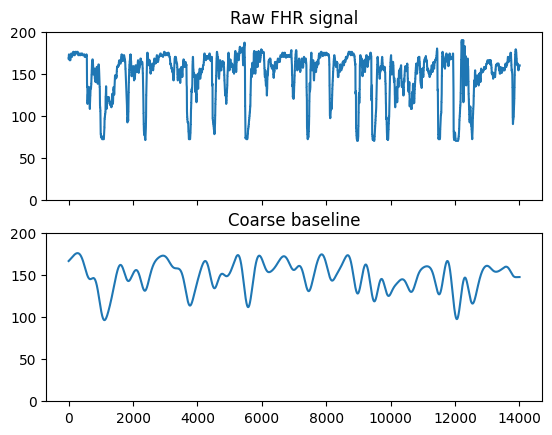

In [6]:
# Generate butterworth filter
sos = butter(
    N=3, # Filter's order
    Wn=0.008, # Critical frequency
    btype='low', # Kind of filter
    fs = 4, # Sampling frequency
    output='sos' # Output type
)

# Use filtfilt() (instead of sosfilt) as it applies the filter
# twice, forwards and backwards, so you get zero-phase filtering
coarse = sosfiltfilt(sos, fhr)

# Plot before and after
print(f'Raw mean: {fhr.mean()}')
print(f'Coarse mean: {coarse.mean()}')
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(fhr)
ax1.set_ylim([0, 200])
ax1.set_title('Raw FHR signal')
ax2.plot(coarse)
ax2.set_ylim([0, 200])
ax2.set_title('Coarse baseline')
plt.show()

#### Step 3: Apply three rounds of removing deivations, interpolation, and butterworth filters

Remove deviations of +- 5bpm from the initial baseline. Then linear interpolation. Then low pass Butterworth filter with cut-off frequency of 0.006 Hz. This was a lower cut off frequency than that used for obtaining the starting baseline, because many of the deviations from the baseline had already been removed in the first filtering process that generated the starting baseline.

Repeat that twice more. This creates a three-stage process the generates progressively improved intermediary baselines.

In [7]:
def taylor_processes(input, show_plot=False):
    '''
    Apply the processes described above to the signal - remove deviations more
    than 5bpm from baseline of input signal, fill with linear interpolation,
    then apply low-pss Butterworth filter with cut-off 0.006Hz.
    Inputs:
    input - numpy array
    '''
    # Find initial baseline
    baseline = input.mean()

    # Find minimum and maximum of input signal
    y_min = input.min()
    y_max = input.max()

    # Set to NaN if +- 5pm from that baseline
    signal = input.copy()
    signal[signal < baseline-5] = np.nan
    signal[signal > baseline+5] = np.nan

    # Replace missing values using linear interpolation
    new_sig = linear_interpolate(pd.Series(signal))

    # Create butterworth filter
    sos = butter(
        N=3, # Filter's order
        Wn=0.006, # Critical frequency
        btype='low', # Kind of filter
        fs = 4, # Sampling frequency
        analog=False, # Return digital filter
        output='sos' # Output type
    )

    # Apply butterworth filter
    final_sig = sosfiltfilt(sos, new_sig)

    # Plot the results from this process
    if show_plot:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
        ax1.plot(input)
        ax1.set_title('Input signal')
        ax1.set_ylim([y_min, y_max])
        ax2.plot(new_sig)
        ax2.set_title('Signal after removing deviations + linear interpolation')
        ax2.set_ylim([y_min, y_max])
        ax3.plot(final_sig)
        ax3.set_title('Final signal, after butterworth')
        ax3.set_ylim([y_min, y_max])
        plt.show()

    # Return processes signal
    return final_sig

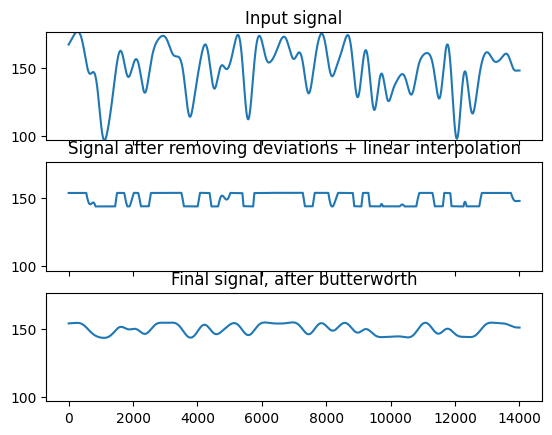

In [8]:
intermediary_1 = taylor_processes(coarse, show_plot=True)

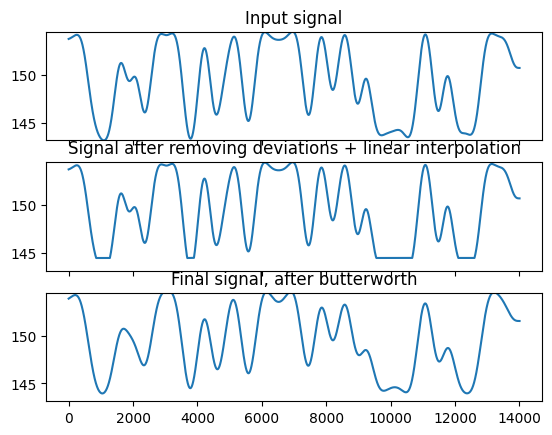

In [9]:
intermediary_2 = taylor_processes(intermediary_1, show_plot=True)

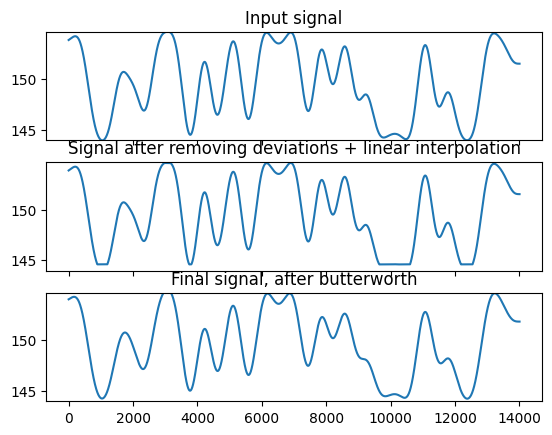

In [10]:
final_sig = taylor_processes(intermediary_2, show_plot=True)

#### Step 4: Find mean

In [11]:
fhr_baseline = final_sig.mean()
fhr_baseline

149.62481413632025

#### Implement as a single function

In [12]:
def taylor_baseline(signal, show_plot=False):
    '''
    Find FHR baseline using method from Taylor et al. 2000
    Utilises the functions:
    - linear_interpolate()
    - fhr_processes()
    Inputs:
    signal - pd Series with FHR in bpm
    show_plot - boolean, whether to show plot of the function as its processed
    '''
    # INTERPOLATE INVALID DATA
    # Set outliers to NaN
    signal[signal < 55] = np.nan
    signal[signal > 200] = np.nan
    # Replace missing values using linear interpolation
    signal = linear_interpolate(signal)

    # GENERATE COARSE BASELINE
    # Generate butterworth filter
    sos = butter(
        N=3, # Filter's order
        Wn=0.008, # Critical frequency
        btype='low', # Kind of filter
        fs = 4, # Sampling frequency
        output='sos' # Output type
    )
    # Use filtfilt() (instead of sosfilt) as it applies the filter
    # twice, forwards and backwards, so you get zero-phase filtering
    coarse = sosfiltfilt(sos, signal)

    # Plot before and after
    if show_plot:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        ax1.plot(fhr)
        ax1.set_ylim([0, 200])
        ax1.set_title('Raw FHR signal')
        ax2.plot(coarse)
        ax2.set_ylim([0, 200])
        ax2.set_title('Coarse baseline')
        plt.show()

    # APPLY 3 ROUNDS OF REMOVING DEVIATIONS, INTERPOLATION + BUTTERWORTH FILTERS
    intermediary_1 = taylor_processes(coarse, show_plot)
    intermediary_2 = taylor_processes(intermediary_1, show_plot)
    final_sig = taylor_processes(intermediary_2, show_plot)

    # FIND BASELINE
    return final_sig

Implement on the example from above

In [13]:
taylor_baseline(original_fhr, show_plot=False).mean()

149.62481413632025

### Validation against FHRMA

To check my baseline calculation using Taylor's method against those available in the FHRMA toolbox using Taylor's method, I have downloaded the files:
* **T_orig.mat** = calculations of FHR baseline and start and end of accelerations using Taylor et al.'s method for each of the .fhr files
* **T_std.mat** = includes accelerations and decelerations identified using a standard method, as FHRMA apply this to all the baseline methods, since some of them don't have any method provided.

#### Import FHRMA Taylor et al. 2000 FHR baseline signal

Baseline, accelerations and decelerations as calculated using the method from Taylor et al. 2000.

In [14]:
# Load Taylor results
t_orig = io.loadmat(paths.fhrma_taylor)

In [15]:
# Get array listing filenames (and hence order of the data)
fhrma_files = np.concatenate(np.concatenate(t_orig['data']['filename']))

# Get array with the baseline signal as per Taylor et al. 2000 from FHRMA
fhrma_t1 = np.concatenate(t_orig['data']['baseline'])

# Convert array into dictionary so each record is accompanied by relevant name
fhrma_taylor = {
    fhrma_files[i].replace('.fhr', ''): 
    fhrma_t1[i][0] for i in range(len(fhrma_files))}

#### Import the cleaned FHR files

These are the CTG data that we will calculate baseline on and compare against the baseline in FHRMA.

In [16]:
def import_csv(directory, output_dict):
    '''
    Import csv files from provided directory and save to output_dict

    Parameters:
    -----------
    directory : string
        Location of csv files
    output_dict : dictionary
        Dictionary to save the FHR arrays to, with key as the record name
        (manually specified in case you would to append to existing dictionary)

    Returns:
    --------
    output_dict : dictionary
        Dictionary of the FHR arrays
    '''
    # Get list of .csv files in directory
    files = glob.glob(os.path.join(directory, '*.csv'))

    # Loop through files in the directory
    for file in files:
        # Get raw name of record (without path or file type)
        name = file.replace(directory, '').replace('.csv', '')
        # Import and save to dictionary
        output_dict[name] = pd.read_csv(file, header=None)[0].values

    return output_dict

In [17]:
# Import FHR into dictionary
clean_fhr = import_csv(
    directory=paths.clean_fhr,
    output_dict=dict())

# Preview an example
clean_fhr['test01']

array([120.25, 120.25, 120.  , ..., 111.  , 112.75, 112.75])

#### Apply my implementation of Taylor et al. 2000 to the FHR

In [18]:
# Create dictionary to store results
python_taylor = dict()

for key, value in clean_fhr.items():
    python_taylor[key] = taylor_baseline(pd.Series(value), show_plot=False)

#### Compare results

Single example...

In [19]:
display(python_taylor['test01'])
display(python_taylor['test01'].mean())

array([120.5773734 , 120.57800409, 120.57864479, ..., 115.56559111,
       115.56559111, 115.56559111])

119.8148387884934

In [20]:
display(fhrma_taylor['test01'])
display(fhrma_taylor['test01'].mean())

array([120.49712748, 120.50097801, 120.5048237 , ..., 112.04091853,
       112.04091837, 112.04091825])

120.44710720618109

Comparison of all records...

In [21]:
# Find mean of each record and combine dataframes
python_df = pd.DataFrame({
    'record': python_taylor.keys(),
    'python_mean': [python_taylor[i].mean() for i in python_taylor.keys()]})
fhrma_df = pd.DataFrame({
    'record': fhrma_taylor.keys(),
    'fhrma_mean': [fhrma_taylor[i].mean() for i in fhrma_taylor.keys()]})
compare_mean = pd.merge(python_df, fhrma_df, on='record')
compare_mean

,record,python_mean,fhrma_mean
0,train28,123.168189,124.339712
1,test80,140.391911,142.115367
2,test68,118.083828,117.999274
3,train04,140.902411,141.312809
4,train31,133.812122,133.400484
...,...,...,...
151,test76,129.646396,130.673578
152,test22,125.640722,126.224606
153,train08,134.197316,133.872200
154,train52,130.488755,130.064502


In [22]:
def compare_means(df, x, y, title):
    '''
    Create scatterpol comparing two columns from df.
    Inputs:
    df - dataframe, to plot from
    x - string, name of column for x axis
    y - string, name of column for y axis
    '''
    fig, ax = plt.subplots()
    ax.scatter(x=df[x], y=df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.xlim([100, 200])
    plt.ylim([100, 200])
    plt.grid()
    ax.set_box_aspect(1)
    plt.show()

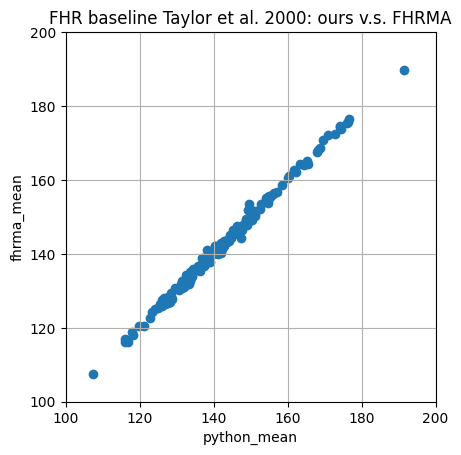

In [23]:
compare_means(compare_mean, 'python_mean', 'fhrma_mean',
              'FHR baseline Taylor et al. 2000: ours v.s. FHRMA')

## Accelerations and decelerations

### Taylor et al. 2000

[Taylor et al. 2000](https://doi.org/10.1111/j.1471-0528.2000.tb11112.x) - The development and validation of an algorithm for real-time computerised fetal heart rate monitoring in labour

**Cleaning signals:** "Both the fetal heart rate and uterine pressure signals contained artefact... Artefact must be removed prior to determining the timing of the decelerations; this is achieved by a low pass fourth order Butterworth filter with a cut off frequency of 0.02 Hz"

**Identifying accelerations and decelerations:** "Accelerations and decelerations were determined and classified according to definitions given by FIGO."

Not performed in FHRMA but also in paper:
* **Classifying decelerations:** "The classification of decelerations was based upon the temporal relationship between the minimum of the deceleration and the maximum of the associated uterine contraction. The uterine contractions were timed by means of an external tocograph. A late deceleration occurred where its minimum value was 20–60 s after the peak of a contraction"
* **Calculating FHR variability:** "The fetal heart rate variability is calculated as twice the standard deviation of the fetal heart rate recorded continuously, after removing the accelerations and decelerations. Reduced variability is defined as one standard deviation < 5 beats per minute."

As you can see, the description of the method for identifying accelerations and decelerations is not clear, and I have followed the interpretation of Boudet et al. below.

### Implementation in MATLAB

Boudet et al. implement Taylor et al. in the FHRMA toolbox, as in [this MATLAB function](https://github.com/utsb-fmm/FHRMA/blob/master/aamtaylor.m) which is copied below.

```
FuzzyLine=butterfilt(FHRi,4,0,0.02,4,1);

% The following is not clearly described on the paper. 
% The begining and ending of accident is described for the baseline caluclation but
% not directly for the accident determination which we guess should be
% different. Here is the sentence which let us suppose our code.
% 
% "Accelerations and decelerations were determined and classified according
% to definitions given by FIGO" 
% "Artefact lust be removed prior to determining the timing of the
% decelerations; this is achieved by a low pass fourth order Butterworth
% filter with a cut off frequency of 0.02Hz"
% Context on those sentences have ambiguities so there is some doubts

if( exist('simpleacc','var') && simpleacc==1)
    [accelerations,decelerations]=simpleaddetection(FHR,baseline);

else
    %List of periods where there is 10bpm difference which are acceleration
    %candidats
    accelerations=startendlist(FuzzyLine-baseline>10)/4; 
    %Delete periods of too short duration or too low amplitude
    accelerations=validaccident(accelerations,FHRi-baseline,15,15); 


    decelerations=startendlist(FuzzyLine-baseline<-5)/4;
    decelerations=validaccident(decelerations,baseline-FHRi,15,15);
end
``````

Their function for simple accleration and deceleration detection:

```
% TRivial method for Acceleration/Deceleration detection
%
% USAGE
%    [acc,dec,falseacc,falsedec]=simpleaddetection(fhr,baseline)
%         
%
% INPUT
%     FHR       : Fetal Heart Rate sampled at 4Hz
%     baseline  : baseline sampled at 4Hz
%
% OUTPUT
%     acc       : 3xn for each n acceleration [start end max]
%     dec       : 3xn for each n deceleraiton [start end max]
%     falseacc  : Same for acceleration with only 5 bpm high
%     falsedec  : Same for deceleration with only 5 bpm high
% 

%123456789012345678901234567890123456789012345678901234567890123456789012
%
%     FHR Morphological Analysis Toolbox  Copyright (C) 2018 Samuel Boudet, Faculté de Médecine et Maïeutique,
%     samuel.boudet@gmail.com
%
%     This file is part of FHR Morphological Analysis Toolbox 
%
%     FHR Morphological Analysis Toolbox  is free software: you can redistribute it and/or modify
%     it under the terms of the GNU General Public License as published by
%     the Free Software Foundation, either version 3 of the License, or
%     (at your option) any later version.
% 
%     FHR Morphological Analysis Toolbox  is distributed in the hope that it will be useful,
%     but WITHOUT ANY WARRANTY; without even the implied warranty of
%     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
%     GNU General Public License for more details.
% 
%     You should have received a copy of the GNU General Public License
%     along with this program.  If not, see <http://www.gnu.org/licenses/>.
%



function [acc,dec,falseacc,falsedec]=simpleaddetection(fhr,baseline)

acc=detectaccident(fhr-baseline,15);
dec=detectaccident(baseline-fhr,15);
falseacc=minusint(acc,detectaccident(fhr-baseline,5));
falsedec=minusint(dec,detectaccident(baseline-fhr,5));
end

function accidentsample=detectaccident(sig,thre)

peaks=find(sig>thre);
accidentsample=zeros(3,0);
while ~isempty(peaks)
    dacc=find(sig(1:peaks)<0,1,'last');
    if isempty(dacc)
        dacc=1;
    end
    facc=find(sig(dacc+1:end)<0,1,'first')+dacc;
    if isempty(facc)
        facc=length(sig);
    end
    [~,macc]=max(sig(dacc:facc));
    macc=macc+dacc-1;
    if facc-dacc>15*4
        accidentsample=[accidentsample [dacc;facc;macc]/4];
    end   
    peaks=peaks(peaks>facc);
end
end

function f=minusint(a,f)

for i=1:size(a,2)
    n=find(f(1,:)>=a(1,i) &f(2,:)<=a(2,i));
    if ~isempty(n)
        f=f(:,[1:n-1 n+1:end]);
    end
end
    
end
```

In [24]:
# Not presently implemented